In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
food_atlas_sheets = ['Supplemental Data - County', 'STORES', 'SOCIOECONOMIC']
food_atlas = pd.read_excel('Data/Food environment atlas.xls', sheet_name=food_atlas_sheets)
income = pd.read_csv('Data/15incyallagi.csv', usecols=[0,2,4,5])
education_columns = ['GEO.id2','HC02_EST_VC17', 'HC04_EST_VC17', 'HC06_EST_VC17', 
                     'HC02_EST_VC18', 'HC04_EST_VC18', 'HC06_EST_VC18']
education = pd.read_csv('Data/ACS_15_5YR_S1501_with_ann.csv',usecols=education_columns, skiprows=[1], encoding='latin-1')

After looking through the data dictionary, these are the columns that contain the percent of the population (total, male, and female) who have completed high school or bachelor's+

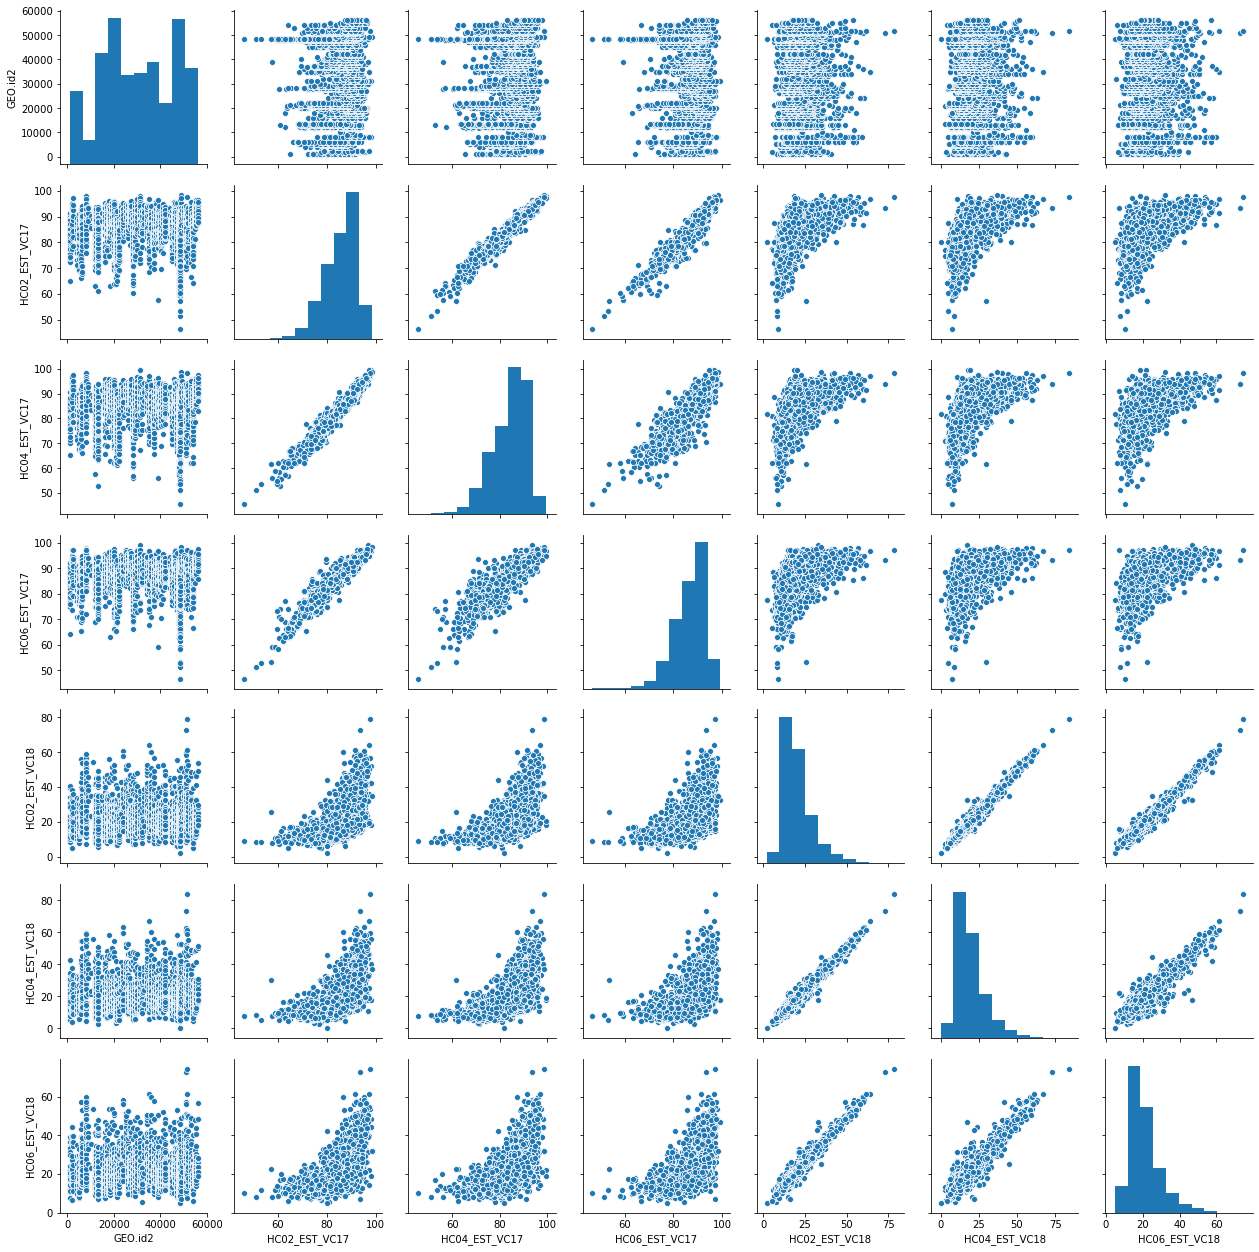

In [3]:
sns.pairplot(education)

The male and female percentages correlate highly with each other and the total so I will keep only the totals

In [4]:
#The FIPS used in the food atlas is a concatination of the STATEFIPS and a 3-digit COUNTYFIPS
income['FIPS'] = (income['STATEFIPS'].astype(str) + income['COUNTYFIPS'].astype(str).apply(str.rjust, args=(3,'0'))).astype(int)
income_pivot = income.pivot_table(index='FIPS', columns='agi_stub', values='N1', margins=True, aggfunc=sum)
for col in income_pivot.columns:
    income_pivot[col] = income_pivot[col] / income_pivot['All']
income_pivot.drop('All', axis='columns', inplace=True)
income_pivot.columns = ['income_pct' + str(x) for x in range(1,9)]
income_pivot = income_pivot.reset_index()
income_pivot.head()

,FIPS,income_pct1,income_pct2,income_pct3,income_pct4,income_pct5,income_pct6,income_pct7,income_pct8
0,1000,0.012622,0.143206,0.264080,0.240945,0.127141,0.081076,0.102979,0.027951
1,1001,0.008347,0.134391,0.229549,0.233306,0.137730,0.104758,0.135225,0.016694
2,1003,0.018896,0.144084,0.229547,0.222783,0.130234,0.090724,0.125832,0.037900
3,1005,0.017727,0.164755,0.326382,0.256517,0.098019,0.058394,0.067779,0.010428
4,1007,0.010050,0.129397,0.273869,0.262563,0.150754,0.082915,0.080402,0.010050


In [5]:
county_data = food_atlas['Supplemental Data - County'].loc[:,['FIPS', 'County', 'State', 'Population Estimate, 2015']].copy()
county_data['County'] = county_data['County'].str.strip()
county_data['State'] = county_data['State'].str.strip()

In [6]:
stores = food_atlas['STORES'].loc[:,['FIPS', 'GROCPTH14', 'SUPERCPTH14', 'CONVSPTH14']].copy()
stores['conv_to_groc'] = (stores['CONVSPTH14'] / (stores['GROCPTH14'] + stores['SUPERCPTH14'])).replace(np.inf, np.nan)

In [7]:
socioeconomic = food_atlas['SOCIOECONOMIC'].copy()
socioeconomic.drop(['State', 'County'], axis='columns', inplace=True)

In [8]:
education_keep = education.loc[:,['GEO.id2', 'HC02_EST_VC17', 'HC02_EST_VC18']].copy()
education_keep.columns = ['FIPS', 'high_school_pct', 'bachelor_pct']

In [9]:
merge1 = county_data.merge(stores, how='left', on='FIPS')
merge2 = merge1.merge(socioeconomic, how='left', on='FIPS')
merge3 = merge2.merge(education_keep, how='left', on='FIPS')
merge4 = merge3.merge(income_pivot, how='left', on='FIPS')
merge4 = merge4.set_index(['State', 'County','FIPS'])
merge4.head()

Population Estimate, 2015  GROCPTH14  SUPERCPTH14  \
State   County  FIPS                                                     
Alabama Autauga 1001                    55,035   0.072209     0.018052   
        Baldwin 1003                   203,690   0.144920     0.029983   
        Barbour 1005                    26,270   0.185963     0.037193   
        Bibb    1007                    22,561   0.222163     0.044433   
        Blount  1009                    57,676   0.103952     0.017325   

                      CONVSPTH14  conv_to_groc  PCT_NHWHITE10  PCT_NHBLACK10  \
State   County  FIPS                                                           
Alabama Autauga 1001    0.541565      5.999998      77.246156      17.582599   
        Baldwin 1003    0.589673      3.371428      83.504787       9.308425   
        Barbour 1005    0.706661      3.166667      46.753105      46.691190   
        Bibb    1007    0.666489      2.500000      75.020729      21.924504   
        Blount  1009    0.467784      3.857143      88.887338       1.263040   

                      PCT_HISP10  PCT_NHASIAN10  PCT_NHNA10  ...  \
State   County  FIPS                                         ...   
Alabama Autauga 1001    2.400542       0.855766    0.397647  ...   
        Baldwin 1003    4.384824       0.735193    0.628755  ...   
        Barbour 1005    5.051535       0.389700    0.218524  ...   
        Bibb    1007    1.771765       0.096007    0.279293  ...   
        Blount  1009    8.070200       0.200621    0.497191  ...   

                      high_school_pct  bachelor_pct  income_pct1  income_pct2  \
State   County  FIPS                                                            
Alabama Autauga 1001             87.2          23.2     0.008347     0.134391   
        Baldwin 1003             89.5          29.0     0.018896     0.144084   
        Barbour 1005             73.3          12.5     0.017727     0.164755   
        Bibb    1007             80.7          10.6     0.010050     0.129397   
        Blount  1009             78.5          12.9     0.014986     0.139419   

                      income_pct3  income_pct4  income_pct5  income_pct6  \
State   County  FIPS                                                       
Alabama Autauga 1001     0.229549     0.233306     0.137730     0.104758   
        Baldwin 1003     0.229547     0.222783     0.130234     0.090724   
        Barbour 1005     0.326382     0.256517     0.098019     0.058394   
        Bibb    1007     0.273869     0.262563     0.150754     0.082915   
        Blount  1009     0.230699     0.257947     0.157130     0.098093   

                      income_pct7  income_pct8  
State   County  FIPS                            
Alabama Autauga 1001     0.135225     0.016694  
        Baldwin 1003     0.125832     0.037900  
        Barbour 1005     0.067779     0.010428  
        Bibb    1007     0.080402     0.010050  
        Blount  1009     0.088556     0.013170  

[5 rows x 30 columns]

In [10]:
merge4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3142 entries, (Alabama, Autauga, 1001) to (Wyoming, Weston, 56045)
Data columns (total 30 columns):
Population Estimate, 2015    3142 non-null object
GROCPTH14                    3140 non-null float64
SUPERCPTH14                  3140 non-null float64
CONVSPTH14                   3140 non-null float64
conv_to_groc                 3072 non-null float64
PCT_NHWHITE10                3140 non-null float64
PCT_NHBLACK10                3140 non-null float64
PCT_HISP10                   3140 non-null float64
PCT_NHASIAN10                3140 non-null float64
PCT_NHNA10                   3140 non-null float64
PCT_NHPI10                   3140 non-null float64
PCT_65OLDER10                3140 non-null float64
PCT_18YOUNGER10              3140 non-null float64
MEDHHINC15                   3139 non-null float64
POVRATE15                    3139 non-null float64
PERPOV10                     3140 non-null float64
CHILDPOVRATE15               3139 n

In [11]:
merge4[merge4.drop('conv_to_groc', axis=1).isna().sum(axis='columns') > 0]

,,,"Population Estimate, 2015",GROCPTH14,SUPERCPTH14,CONVSPTH14,conv_to_groc,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,...,high_school_pct,bachelor_pct,income_pct1,income_pct2,income_pct3,income_pct4,income_pct5,income_pct6,income_pct7,income_pct8
State,County,FIPS,,,,,,,,,,,,,,,,,,,,,
Alaska,Kusilvak,2158,"8,109",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.5,5.0,0.00000,0.422713,0.271293,0.182965,0.072555,0.028391,0.022082,0.0
Hawaii,Kalawao,15005,88,0.0,0.0,0.0,NaN,26.666667,0.0,1.111111,7.777778,0.0,...,88.5,34.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
South Dakota,Oglala Lakota,46102,"14,383",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.8,11.4,0.01005,0.233668,0.276382,0.309045,0.100503,0.040201,0.030151,0.0


In [12]:
merge4.dropna(thresh=29, inplace=True)

In [13]:
merge4['Population Estimate, 2015'] = merge4['Population Estimate, 2015'].str.replace(',', '').astype('float64')
merge4['METRO13'] = merge4['METRO13'].astype('category')
merge4['PERCHLDPOV10'] = merge4['PERCHLDPOV10'].astype('category')
merge4['PERPOV10'] = merge4['PERPOV10'].astype('category')
merge4['POPLOSS10'] = merge4['POPLOSS10'].astype('category')
merge4.columns = merge4.columns.str.lower()

In [14]:
merge4.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"population estimate, 2015",3139.0,102221.738770,328271.245408,115.000000,11007.000000,25718.000000,67640.500000,1.011226e+07
grocpth14,3139.0,0.251606,0.219315,0.000000,0.138699,0.194491,0.284615,3.149606e+00
supercpth14,3139.0,0.018292,0.023213,0.000000,0.000000,0.014171,0.029013,2.480774e-01
convspth14,3139.0,0.595900,0.310960,0.000000,0.400400,0.544366,0.723386,4.601227e+00
conv_to_groc,3072.0,2.753123,1.647709,0.000000,1.666667,2.400000,3.444445,1.700000e+01
pct_nhwhite10,3139.0,78.360313,19.787545,2.860408,67.014549,85.774059,94.180771,9.916318e+01
pct_nhblack10,3139.0,8.753403,14.426701,0.000000,0.400913,1.907184,9.732428,8.543878e+01
pct_hisp10,3139.0,8.292461,13.196929,0.000000,1.594090,3.285739,8.235463,9.574477e+01
pct_nhasian10,3139.0,1.135387,2.468433,0.000000,0.270060,0.463388,0.985868,4.301469e+01
pct_nhna10,3139.0,1.813536,7.242930,0.000000,0.194973,0.305003,0.625699,8.631918e+01


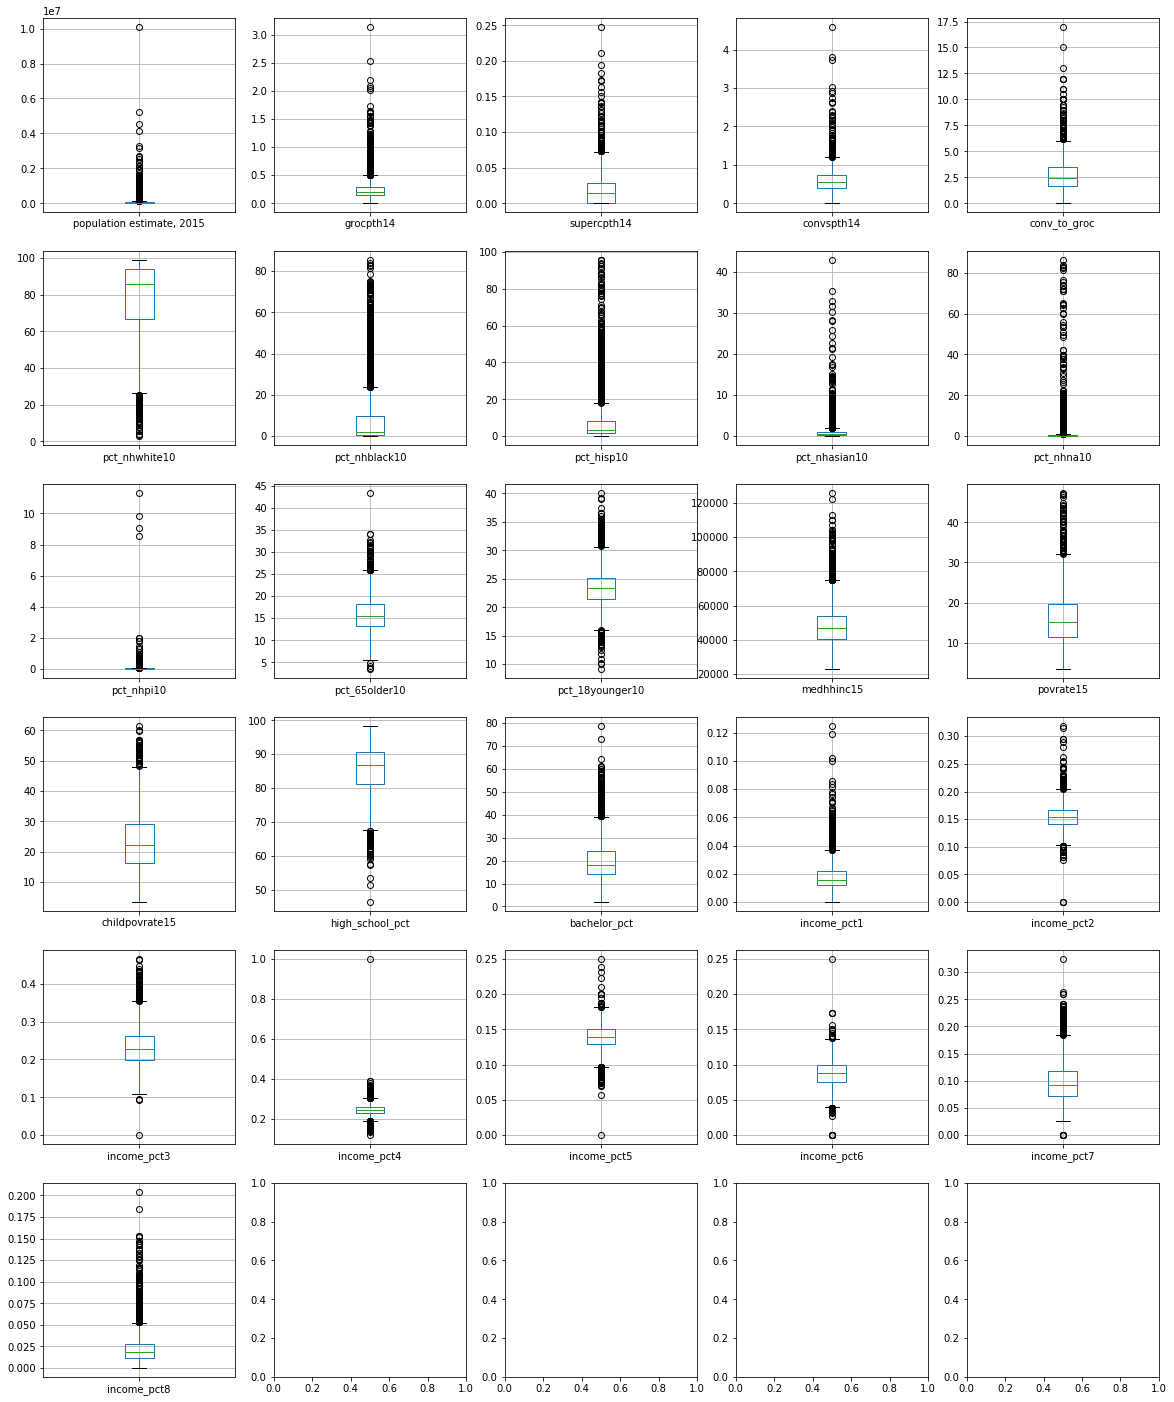

In [15]:
continuous = merge4.loc[:,merge4.dtypes == 'float64'].copy()
f, axes = plt.subplots(6, 5, figsize=(20,25))
for k, col in enumerate(continuous.columns):
    continuous.boxplot(column=col, ax=axes[k//5, k%5])

In [16]:
merge4.to_pickle('Data/capstone1_data.pkl')
merge4.to_csv('Data/capstone1_data.csv')